# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.tree import DecisionTreeClassifier


# Import the Dataset

In [2]:
yelp_reviews = pd.read_csv('yelp.csv')

In [3]:
yelp_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


# Data Preprocessing

In [4]:
# remove the columns that dont add any value
yelp_reviews = yelp_reviews.drop(['business_id', 'review_id', 'user_id', 'date'], axis=1)

In [5]:
yelp_reviews.head()

,stars,text,type,cool,useful,funny
0,5,My wife took me here on my birthday for breakf...,review,2,5,0
1,5,I have no idea why some people give bad review...,review,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,review,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,review,0,0,0


In [6]:
yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   10000 non-null  int64 
 1   text    10000 non-null  object
 2   type    10000 non-null  object
 3   cool    10000 non-null  int64 
 4   useful  10000 non-null  int64 
 5   funny   10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


In [7]:
yelp_reviews['text'][0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

# Exploratory data analysis

In [8]:
yelp_reviews['text len'] = yelp_reviews['text'].apply(len)

In [9]:
yelp_reviews.head(2)

,stars,text,type,cool,useful,funny,text len
0,5,My wife took me here on my birthday for breakf...,review,2,5,0,889
1,5,I have no idea why some people give bad review...,review,0,0,0,1345


<AxesSubplot:ylabel='Frequency'>

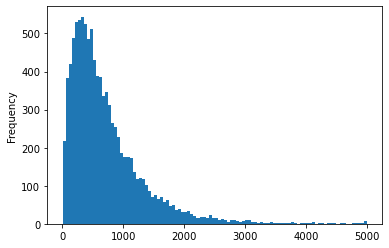

In [10]:
# histogram of text len
yelp_reviews['text len'].plot(bins = 100, kind = 'hist')

In [11]:
yelp_reviews['text len'].describe()

count    10000.000000
mean       710.738700
std        617.399827
min          1.000000
25%        294.000000
50%        541.500000
75%        930.000000
max       4997.000000
Name: text len, dtype: float64

In [12]:
yelp_reviews[yelp_reviews['text len'] == yelp_reviews['text len'].max()]['text']

55    In our continuing quest to identify cool, loca...
Name: text, dtype: object

<AxesSubplot:xlabel='count', ylabel='stars'>

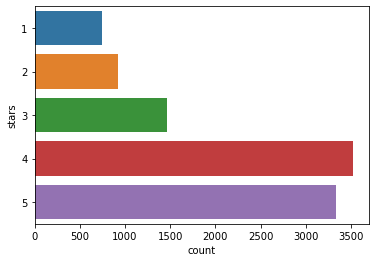

In [13]:
# count different categories
sns.countplot(y = 'stars', data = yelp_reviews)

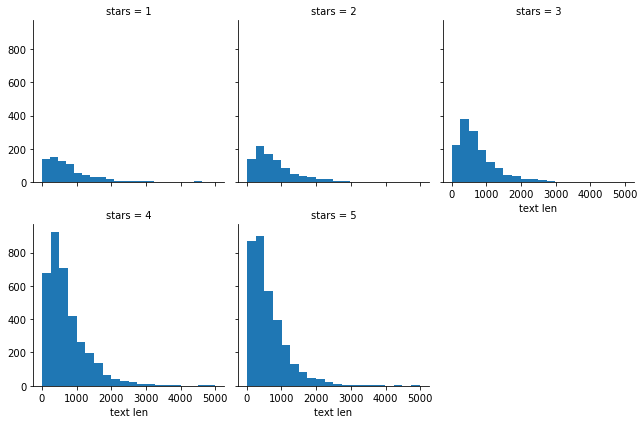

In [14]:
# distribution of text length in different categories
g = sns.FacetGrid(data = yelp_reviews,col = 'stars', col_wrap = 3)
g.map(plt.hist, 'text len', bins = 20)

In [15]:
print('1-star review % = ', str(len(yelp_reviews[yelp_reviews['stars']==1])/len(yelp_reviews) * 100) + '%')
print('2-star review % = ', str(len(yelp_reviews[yelp_reviews['stars']==2])/len(yelp_reviews) * 100) + '%')
print('3-star review % = ', str(len(yelp_reviews[yelp_reviews['stars']==3])/len(yelp_reviews) * 100) + '%')
print('4-star review % = ', str(len(yelp_reviews[yelp_reviews['stars']==4])/len(yelp_reviews) * 100) + '%')
print('5-star review % = ', str(len(yelp_reviews[yelp_reviews['stars']==5])/len(yelp_reviews) * 100) + '%')

1-star review % =  7.489999999999999%
2-star review % =  9.27%
3-star review % =  14.610000000000001%
4-star review % =  35.260000000000005%
5-star review % =  33.37%


# Tokenization, Lemmatization, Remove stopwords, Remove punctuations.

In [16]:
# Create corpus
def cleaning_text(messages):
    corpus = []
    for i in range(0, len(messages)):
        review = re.sub('[^a-zA-Z]', ' ', messages[i])
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    print(len(corpus))
    return corpus

corpus = cleaning_text(yelp_reviews['text'])

10000


In [17]:
corpus[0]

'wife took birthday breakfast excel weather perfect made sit outsid overlook ground absolut pleasur waitress excel food arriv quickli semi busi saturday morn look like place fill pretti quickli earlier get better favor get bloodi mari phenomen simpli best ever pretti sure use ingredi garden blend fresh order amaz everyth menu look excel white truffl scrambl egg veget skillet tasti delici came piec griddl bread amaz absolut made meal complet best toast ever anyway wait go back'

In [18]:
label = yelp_reviews['stars'].values
label

array([5, 5, 4, ..., 4, 2, 5])

# Count Vectorizer

In [19]:
cVector = CountVectorizer(max_features = 3000)
yelp_cv = cVector.fit_transform(corpus)

print(cVector.get_feature_names())

['abil', 'abl', 'absolut', 'ac', 'accent', 'accept', 'access', 'accessori', 'accid', 'accommod', 'accomod', 'accompani', 'accord', 'account', 'acknowledg', 'acoust', 'across', 'act', 'action', 'activ', 'actual', 'ad', 'add', 'addict', 'addit', 'address', 'adequ', 'adjust', 'admit', 'ador', 'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic', 'advis', 'afford', 'afraid', 'afternoon', 'afterward', 'age', 'ago', 'agre', 'ah', 'ahead', 'ahi', 'ahwatuke', 'aid', 'aioli', 'air', 'airi', 'airlin', 'airport', 'aisl', 'aj', 'aka', 'al', 'ala', 'albeit', 'alcohol', 'ale', 'alfredo', 'alley', 'allow', 'almond', 'almost', 'alon', 'along', 'alot', 'alreadi', 'alright', 'also', 'altern', 'although', 'alway', 'amaz', 'amazingli', 'amber', 'ambianc', 'ambienc', 'amc', 'amen', 'america', 'american', 'among', 'amount', 'ampl', 'amus', 'angel', 'anim', 'anniversari', 'annoy', 'anoth', 'answer', 'anticip', 'antiqu', 'anyhow', 'anymor', 'anyon', 'anyth', 'anytim', 'anyway', 'anywher', 'apart', '

In [20]:
print(yelp_cv.shape)

(10000, 3000)


# Split the dataset into training and testing data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(yelp_cv, label, test_size=0.2)

# Train the model using Multinomial Naive Bayes Classifier Model

In [22]:
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

# Test the model on test dataset

In [23]:
y_predict = NB_classifier.predict(X_test)

In [24]:
y_predict

array([5, 5, 5, ..., 3, 5, 5])

# Compare the results

In [25]:
for i in range(len(y_predict)):
    print(y_predict[i], y_test[i])

5 5
5 5
5 5
5 5
5 4
4 4
5 5
4 3
5 5
4 4
4 5
4 4
2 2
2 4
4 5
2 2
3 4
5 2
2 2
2 3
2 2
2 3
2 3
3 3
4 4
4 4
2 2
5 3
3 3
5 5
3 3
5 5
5 5
2 2
2 1
4 2
5 5
4 5
5 4
4 5
5 5
4 4
5 5
4 5
4 5
5 4
4 3
5 4
4 3
5 5
4 5
4 4
3 3
2 1
4 4
4 4
5 5
5 4
5 5
5 4
4 4
4 5
5 5
4 4
4 4
5 5
5 4
4 4
5 4
5 5
1 2
5 2
4 4
4 4
5 3
3 2
5 5
1 1
5 4
1 2
4 4
5 5
4 5
5 4
5 5
4 5
4 4
3 3
4 4
3 5
3 3
4 4
2 1
4 4
4 5
4 3
4 5
4 5
5 4
1 3
2 1
4 5
4 4
5 3
1 1
1 2
3 3
2 3
4 4
5 5
5 5
3 2
5 5
3 3
4 5
4 4
1 4
1 3
5 5
5 5
1 1
5 5
4 3
3 3
4 3
5 4
5 5
4 5
4 4
4 4
4 4
5 5
4 4
2 3
3 4
5 5
2 2
2 2
4 4
4 4
5 5
5 4
5 4
5 5
4 4
5 5
4 4
4 4
3 1
5 3
4 4
2 4
3 4
4 4
5 5
5 5
4 1
5 5
4 3
3 3
4 5
1 5
4 3
4 4
4 5
4 4
4 4
4 5
4 5
3 4
1 1
5 5
3 4
3 2
1 3
5 4
4 3
3 2
5 4
5 5
5 5
5 3
4 3
2 5
3 1
5 4
5 5
4 2
3 5
4 5
1 2
5 5
5 5
3 2
4 3
4 5
3 2
1 3
4 4
3 3
5 5
5 1
5 4
5 4
4 5
4 5
5 5
1 1
3 3
3 2
5 5
5 5
2 2
2 5
5 4
4 4
3 3
1 1
5 5
3 3
3 5
4 5
4 5
4 5
5 4
4 5
3 3
5 4
4 4
4 4
5 4
5 3
5 5
4 4
3 4
4 5
1 2
3 3
4 4
3 2
5 5
4 4
4 3
4 3
1 1
4 3
5 5
4 5
3 2
4 4


# Evaluate Model

In [26]:
print(confusion_matrix(y_test, y_predict))

[[ 83  33  22   4  13]
 [ 54  57  42  24  14]
 [ 29  27  99 123  34]
 [ 15  12  69 397 194]
 [ 19  11  11 207 407]]


<AxesSubplot:>

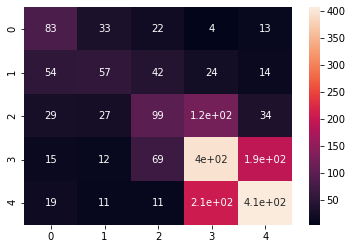

In [27]:
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

In [28]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.41      0.54      0.47       155
           2       0.41      0.30      0.34       191
           3       0.41      0.32      0.36       312
           4       0.53      0.58      0.55       687
           5       0.61      0.62      0.62       655

    accuracy                           0.52      2000
   macro avg       0.47      0.47      0.47      2000
weighted avg       0.52      0.52      0.52      2000



# Classify the review based on text 

In [29]:
text1 = ['amazing food. highly recommended']
#text1 = cleaning_text(text1)

#text1=[text1]
text_cleaned = cVector.transform(text1)

print(NB_classifier.predict(text_cleaned))

[4]


In [30]:
text1 = ['bad food made me sick']
#text1 = cleaning_text(text1)

#text1=[text1]
text_cleaned = cVector.transform(text1)

print(NB_classifier.predict(text_cleaned))

[1]
